## Network Analysis of Risk Factors

Analyze the network of risk factor papers - based on connections of papers that discuss multiple risk factors.

This network analysis is based on inferring connections based on articles that discuss multiple factors (based on matching article IDs).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from lisc.utils import SCDB, load_object

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_network

## Setup

In [4]:
# Settings
SAVE_FIG = True
SAVE_EXT = '.pdf'

In [5]:
# Set the name of the file to load
name = 'blue_health_factors'  # 'blue_health_factors', 'test'

# Set the minimum number of papers for including a component
n_min = 2000

In [6]:
# Set the file locations
from lisc.utils import SCDB
db = SCDB('../data')
figs_dir = '../data/figures/network/'

# Ensure the figures directory exists
import os
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [7]:
from pathlib import Path
from os.path import relpath
from lisc.io import load_object
from lisc.utils import SCDB

def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    while p != p.parent:
        if (p / ".git").exists() or (p / "data").exists():
            return p
        p = p.parent
    raise RuntimeError("No s'ha trobat l'arrel del repo.")

REPO_ROOT = find_repo_root()
DATA_DIR   = REPO_ROOT / "data"
WORDS_DIR  = DATA_DIR / "words"
COUNTS_DIR = DATA_DIR / "counts"

db = SCDB(str(REPO_ROOT))      # ⚠️ no posar-hi '/data'

# Assegura carpetes
WORDS_DIR.mkdir(parents=True, exist_ok=True)
COUNTS_DIR.mkdir(parents=True, exist_ok=True)

# Impressió 100% relativa i segura
print("REPO_ROOT:", relpath(str(REPO_ROOT), start=str(Path.cwd())))
print("WORDS_DIR:", relpath(str(WORDS_DIR), start=str(REPO_ROOT)))
print("COUNTS_DIR:", relpath(str(COUNTS_DIR), start=str(REPO_ROOT)))


REPO_ROOT: ..
WORDS_DIR: data/words
COUNTS_DIR: data/counts


In [8]:
# --- Loader 100% relatiu i robust per a words_*.p ---

from pathlib import Path
from os.path import relpath
import pickle
from lisc.io import load_object as lisc_load_object

def find_repo_root(start: Path | None = None) -> Path:
    """Troba l'arrel del repo pujant fins trobar '.git' o 'data/'."""
    p = (start or Path.cwd()).resolve()
    while p != p.parent:
        if (p / ".git").exists() or (p / "data").exists():
            return p
        p = p.parent
    raise RuntimeError("No s'ha trobat l'arrel del repo (no veig '.git' ni 'data/').")

def load_words_safely(target: str):
    """
    Carrega un objecte Words de LISC de forma robusta.
    target: 'blue_health_factors' o 'blue_health_exposure_metrics'
            (amb o sense prefix 'words_')
    Prova lisc.load_object i, si falla, fa fallback a pickle.
    """
    root = find_repo_root()
    words_dir = root / "data" / "words"
    words_dir.mkdir(parents=True, exist_ok=True)

    name = target if target.startswith("words_") else f"words_{target}"
    p = words_dir / f"{name}.p"

    print("Repo root:", relpath(str(root), start=str(Path.cwd())))
    print("Carpeta words:", relpath(str(words_dir), start=str(root)))
    print("Fitxer objectiu:", p.name)

    if not p.exists():
        avail = [q.name for q in sorted(words_dir.glob("words_*.p"))]
        raise FileNotFoundError(
            f"No trobo {p.name} a {relpath(str(words_dir), start=str(root))}. "
            f"Disponibles: {avail}"
        )

    # 1) Intent amb LISC (name + directory)
    try:
        obj = lisc_load_object(p.stem, directory=str(words_dir), reload_results=True)
        print("[ok] Carregat amb lisc.load_object")
        return obj
    except Exception as e:
        print("[warn] lisc.load_object ha fallat →", e)

    # 2) Fallback a pickle (path complet)
    with open(p, "rb") as fh:
        obj = pickle.load(fh)
    print("[info] Carregat via pickle (fallback).")
    return obj

# === Tria quin vols carregar ===
# 'blue_health_factors' o 'blue_health_exposure_metrics'
WORDS_TARGET = "blue_health_factors"

words = load_words_safely(WORDS_TARGET)

# Comprovació mínima
try:
    print("Terms A:", len(words.terms['A'].labels), "Terms B:", len(words.terms['B'].labels))
except Exception:
    pass


Repo root: ..
Carpeta words: data/words
Fitxer objectiu: words_blue_health_factors.p
[warn] lisc.load_object ha fallat → Can not find requested file name.
[info] Carregat via pickle (fallback).


In [9]:
# Check how many risk factors were kept
print('Number of risk factors kept: {}'.format(len(words.results)))

Number of risk factors kept: 60


## Set up Network

In [10]:
# Settings for setting up the network
normalize = True
seed = 28

In [11]:
# Calculate the connections between risk factors, based on overlapping articles
overlaps = np.zeros(shape=(words.n_terms, words.n_terms))
for ii, ei in enumerate(words.labels):
    for jj, ej in enumerate(words.labels):
        if ii == jj:
            continue
        set_ei = set(map(tuple, words.results[ii].ids))  # Convert lists to tuples and then to a set
        set_ej = set(map(tuple, words.results[jj].ids))  # Convert lists to tuples and then to a set
        overlaps[ii, jj] = len(set_ei & set_ej)  # Intersection
        if normalize:
            overlaps[ii, jj] = overlaps[ii, jj] / len(set_ei | set_ej)  # Union


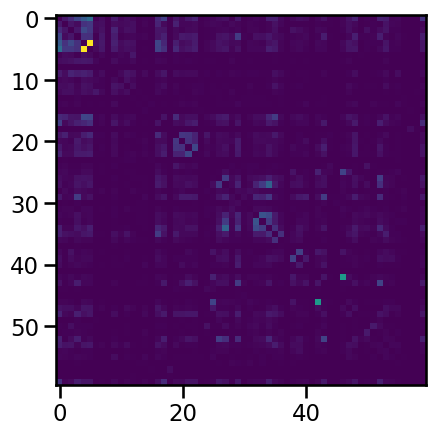

In [12]:
# Plot the weights matrix
plt.imshow(overlaps)

In [13]:
# Initialize network graph, and add the nodes
network = nx.Graph()
for ind, erp in enumerate(words.labels):
    network.add_node(ind)

In [14]:
# Add weighted edges between nodes
for ii in range(words.n_terms):
    for jj in range(words.n_terms):
        if ii == jj: continue
        if overlaps[ii, jj] > 0:
            network.add_edge(ii, jj, weight=overlaps[ii, jj])

In [15]:
# Collect the labels for each node
labels = {ind : label for ind, label in enumerate(words.labels)}

In [16]:
# Check for nodes with no connections, and set to drop
no_edges = [key for key, val in network.degree if val <= 1]

In [17]:
# Check the nodes that are disconnected from the network
drop_labels = [labels[ind] for ind in no_edges]
print('Disconnected nodes to drop: ', ' , '.join(drop_labels))

Disconnected nodes to drop:  Fear of water


In [18]:
# Drop disconnected risk factors: factors without connections to the network are dropped
for ind in no_edges:
    network.remove_node(ind)
    labels.pop(ind, None)

In [19]:
# Check the number of nodes left in the network
print('Number of nodes in the network: {}'.format(len(network.nodes)))

Number of nodes in the network: 59


### Plot the risk factor network

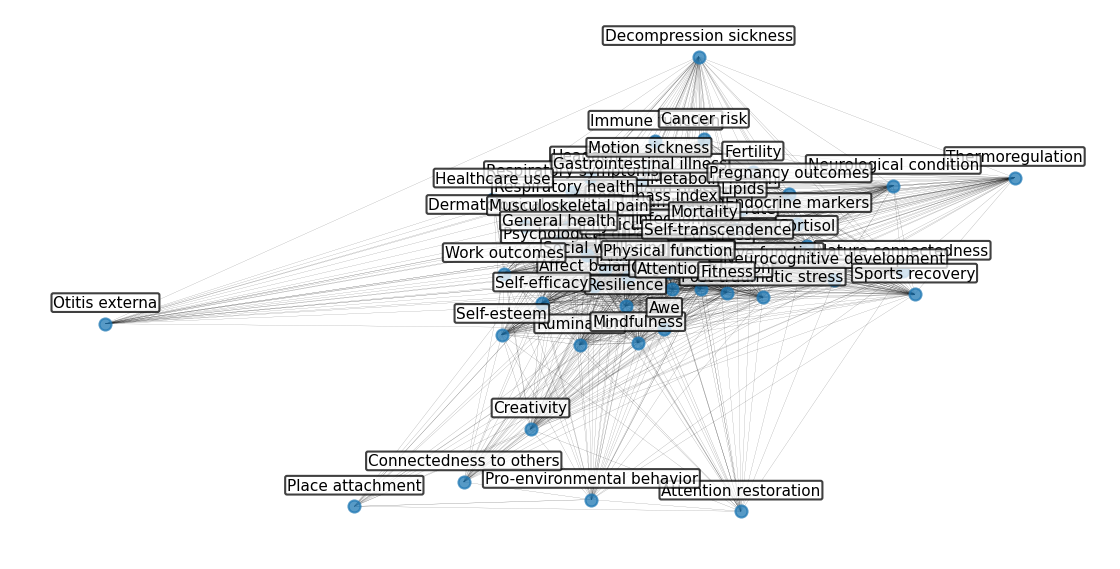

In [20]:
# Plot the network
plot_network(network, labels, layout_seed=seed, figsize=(11, 5.5),
             save_fig=SAVE_FIG, file_name='blue_health_factors_network' + SAVE_EXT,
             directory=figs_dir, save_kwargs={'transparent' : True})

## Measures

Evaluate some descriptive measures of the risk factor network

In [28]:
# Check the total number of possible connections
n_pos_connections = int((len(network) * len(network) - len(network)) / 2)
print('The number of possible connections is: {}'.format(n_pos_connections))

The number of possible connections is: 1711


In [29]:
# Get the number of edges
n_edges = len(network.edges)
print('The number of network edges is: {}'.format(n_edges))

The number of network edges is: 1537


In [30]:
edge_proportion = n_edges / n_pos_connections
print('The percentage of possible edges: {:2.2f} %'.format(edge_proportion * 100))

The percentage of possible edges: 89.83 %


### Network Center

Calculate eccentricity and radius of the network:
- the eccentricity of a node is the maximum distance from the node to all other nodes. 
- the radius is the minimum eccentricity

Find the 'center' of the network - the node(s) with eccentricity equal to radius.

In [31]:
# Check network eccentricity and radius
print('Average eccentricity: \t {:2.2f}'.format(np.mean(list(nx.eccentricity(network).values()))))
print('Network radius: \t', nx.radius(network))

Average eccentricity: 	 1.95
Network radius: 	 1


In [32]:
# Check center(s)
centers = nx.center(network)
print('Network center(s): ', ', '.join([labels[ind] for ind in centers]))

Network center(s):  Psychological distress, Nature connectedness, Awe


### Descriptive Statistics

Check some descriptive measures of the network.

In [33]:
# Check some descriptive statistics of the network
print('Average clustering: \t\t{:1.2f}'.format(nx.average_clustering(network)))
print('Average node connectivity: \t{:1.2f}'.format(nx.average_node_connectivity(network)))
print('Average shortest path length: \t{:1.2f}'.format(nx.average_shortest_path_length(network)))

Average clustering: 		0.95
Average node connectivity: 	48.53
Average shortest path length: 	1.10


### Network Degree

The degree is the number of connections each node has to other nodes. 

In [34]:
# Check average degree
degrees = [val for key, val in network.degree]
print('Average degree: \t\t{:1.2f}'.format(np.median(degrees)))

Average degree: 		55.00


### Edge Weights

Check details and descriptions of the edge weights.

In [35]:
# Check the strongest weight between two nodes
topa = max(dict(network.edges).items(), key=lambda x: x[1]['weight'])
print('Top association: {} & {} - {:1.4f}'.format(labels[topa[0][0]], labels[topa[0][1]], topa[1]['weight']))

Top association: Anxiety & Depression - 0.2964


In [36]:
# Collect the distribution of all weights
all_weights = []
for edge in network.edges:
    all_weights.append(network.edges[edge]['weight'])
print('Average weight value: {:4.4f}'.format(np.median(all_weights)))

Average weight value: 0.0021


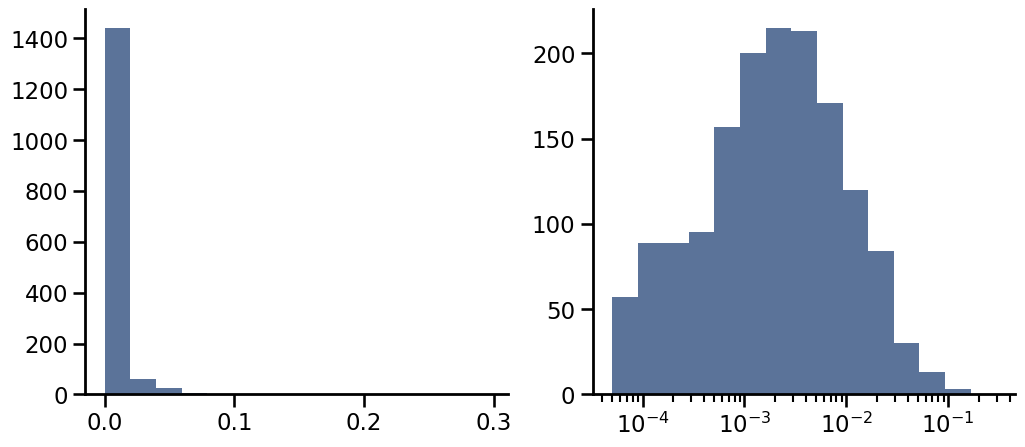

In [37]:
# Plot the distibution of weights, in linear & log spacing
_, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_count_hist(all_weights, bins=15, log=False, ax=axes[0])
plot_count_hist(all_weights, bins=15, log=True, ax=axes[1])

In [38]:
# Collect the set of weights per node
node_weights = []
for node_ind in network.nodes:
    node_edges = [edge for edge in network.edges() if node_ind in edge]
    node_weights.append([network[ne[0]][ne[1]]['weight'] for ne in node_edges])

In [39]:
# Collect the strongest link per node 
max_weight = []
for ind in labels.keys():
    max_ind = max(dict(network[ind]).items(), key=lambda x: x[1]['weight'])[0]
    max_weight.append(labels[max_ind])

### Measures per node

Check measures of interest for each node.

In [40]:
# Check measures per node
print("LABEL\t\tDEGREE\t\tAVG_WEIGHT (  MIN  -  MAX  )\t\tTOP-WEIGHT")
for label, degree, weights, top in zip(labels.values(), degrees, node_weights, max_weight):
    print('{:5s}\t\t{:2d}\t\t{:5.2f}\t   ({:1.4f} - {:3.4f})\t\t{:5s}'.format(\
        label, degree, np.mean(weights), min(weights), max(weights), top))

LABEL		DEGREE		AVG_WEIGHT (  MIN  -  MAX  )		TOP-WEIGHT
Mental health		56		 0.02	   (0.0001 - 0.1062)		Depression
Affect balance		57		 0.01	   (0.0001 - 0.0477)		Depression
Psychological distress		58		 0.01	   (0.0001 - 0.0639)		Anxiety
Perceived stress		55		 0.01	   (0.0003 - 0.0614)		Mental health
Anxiety		57		 0.02	   (0.0001 - 0.2964)		Depression
Depression		56		 0.02	   (0.0001 - 0.2964)		Anxiety
Rumination		56		 0.00	   (0.0001 - 0.0178)		Mindfulness
Post-traumatic stress		55		 0.00	   (0.0001 - 0.0194)		Anxiety
Resilience		57		 0.01	   (0.0001 - 0.0291)		Psychological distress
Self-esteem		56		 0.00	   (0.0001 - 0.0123)		Self-efficacy
Self-efficacy		55		 0.00	   (0.0001 - 0.0158)		Resilience
Mindfulness		56		 0.00	   (0.0001 - 0.0178)		Rumination
Nature connectedness		58		 0.00	   (0.0001 - 0.0027)		Perceived stress
Awe  		58		 0.00	   (0.0001 - 0.0077)		Resilience
Attention restoration		28		 0.00	   (0.0001 - 0.0024)		Awe  
Sleep quality		55		 0.01	   (0.0001 - 0.0615)		Anxiety